# NYC MTA Turnstile Usage Data Challenge
### Minghao Dai,      md3397@columbia.edu
- Description:

  In this data challenge, I used the NYC MTA Turnstile Usage data sets from  http://web.mta.info/developers/turnstile.html to solve 5 data analysis questions and 5 data visualization questions.  
- Outline of structure of the code:
  - Notebook prep
  - Data Analysis
  - Data Visualization

----------
## Notebook Prep

In [1]:
import pandas as pd
import urllib
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np

from datetime import date, timedelta
from collections import Counter
from sklearn.cluster import KMeans

%matplotlib inline
plt.style.use('ggplot')

## Data Analysis

### 1.  Which station has the most number of units? 

In [2]:
rbs = pd.read_csv('Remote-Booth-Station.csv')
stat_nunit = rbs.groupby('Station')['Remote'].nunique()
stat_nunit[stat_nunit == stat_nunit.max()]

Station
86 ST       5
CANAL ST    5
Name: Remote, dtype: int64

+ So there are two stations: '86 ST' and 'CANAL ST' have both the most number of units which is 5. 

### 2.  What is the total number of entries & exits across the subway system for August 1, 2013?

In [5]:
def daily(enddate):
    file = urllib.request.urlopen('http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + str(enddate) + '.txt')
    date = 0
    l = []
    for line in file:
        mylist = str(line,'utf-8').rstrip().split(',')
        for i in list(range(3, len(mylist), 5)):
            d = mylist[i]
            if d != date:
                l.append(mylist[0:3] + mylist[i:i+5])
                date = d
    with open(str(enddate) + '.csv', 'w', newline = '') as rf:
        wr = csv.writer(rf, delimiter = ',')
        wr.writerows(l)

In [ ]:
daily(130803)

In [3]:
d130803 = pd.read_csv('130803.csv', names = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'])

In [4]:
def entry_exit(ddate):
    ddate['ENTRIES_DAILY'] = ddate.ENTRIES.shift(-1) - ddate.ENTRIES
    ddate['EXITS_DAILY'] = ddate.EXITS.shift(-1) - ddate.EXITS
    #remove entires and exits on the last day of one file
    ddate.loc[(ddate.SCP != ddate.SCP.shift(-1)) | (ddate.UNIT != ddate.UNIT.shift(-1)) | 
              (ddate['C/A'] != ddate['C/A'].shift(-1)) | 
              (pd.to_datetime(ddate.DATE, format = '%m-%d-%y') + timedelta(days = 1) != 
               pd.to_datetime(ddate.DATE.shift(-1), format = '%m-%d-%y')), 
              ('ENTRIES_DAILY', 'EXITS_DAILY')] = 0
    #use the new number as daily count after reseting
    ddate.loc[ddate.ENTRIES_DAILY < 0, 'ENTRIES_DAILY'] = ddate.ENTRIES.shift(-1)
    ddate.loc[ddate.EXITS_DAILY < 0, 'EXITS_DAILY'] = ddate.EXITS.shift(-1)    

In [6]:
entry_exit(d130803)

In [7]:
[d130803.ENTRIES_DAILY[d130803.DATE == '08-01-13'].sum(), d130803.EXITS_DAILY[d130803.DATE == '08-01-13'].sum()]

[5564397.0, 4405097.0]

+ The total number of entries & exits across the subway system on August 1, 2013 are 5,564,397 and 4,405,097 seperately. 

### 3.  Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

In [8]:
#define busyness column
d130803['BUSYNESS'] = d130803.ENTRIES_DAILY + d130803.EXITS_DAILY
#add station to dataframe
ucs = rbs[['Remote', 'Booth', 'Station']]
ucs.columns = ['UNIT', 'C/A', 'STATION']
d130803_m = pd.merge(d130803, ucs, how = 'left', on = ['C/A', 'UNIT'])
#analyze busyness on Aug 1st
day130801 = d130803_m.loc[d130803_m.DATE == '08-01-13']
stat_busy_130801 = day130801.groupby('STATION')['BUSYNESS'].sum()
stat_busy_130801[stat_busy_130801 == stat_busy_130801.max()]

STATION
34 ST-PENN STA    331043.0
Name: BUSYNESS, dtype: float64

In [9]:
day130801.loc[day130801.BUSYNESS.idxmax()]

C/A                        N063A
UNIT                        R011
SCP                     00-00-00
DATE                    08-01-13
TIME                    00:00:00
DESC                     REGULAR
ENTRIES                 13558408
EXITS                   47360109
ENTRIES_DAILY               1882
EXITS_DAILY                 9963
BUSYNESS                   11845
STATION          42 ST-PA BUS TE
Name: 8153, dtype: object

+ 34 ST-PENN STA was the busiest on August 1, 2013, with busy-ness 331.043. 
+ The businest turnstile on August 1, 2013 is the turnstile with C/A(Booth)=N063A, UNIT(Remote)=R011, SCP=00-00-00, at station 42 ST-PA BUS TE. 


### 4. What stations have seen the most usage growth/decline in 2013?

In [10]:
#function for all the end dates in a year
def allenddate(year):
    d = date(year, 1, 5)
    l = [d.strftime("%y%m%d")]
    while d.year == year:
        d += timedelta(days = 7)
        l.append(d.strftime("%y%m%d"))    
    return(l)

In [ ]:
#read in all the relevant files in 2013 on daily basis
for enddate in allenddate(2013):
    daily(enddate)

In [11]:
#concatenate 2013 files into one big dataframe
df13 = pd.concat((pd.read_csv(enddate + '.csv', header = None, 
                              names = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']) 
                  for enddate in allenddate(2013))).sort_values(by=['C/A','UNIT', 'SCP', 'DATE'])
#remove dates not in 2013
df13 = df13[(df13.DATE != '12-29-12') & (df13.DATE != '12-30-12') & (df13.DATE != '12-31-12') & 
            (df13.DATE != '01-01-14') & (df13.DATE != '01-02-14') & (df13.DATE != '01-03-14')].reset_index(drop=True)
entry_exit(df13)
#remove abnormal values
df13.loc[(df13.ENTRIES_DAILY < 0) | (df13.EXITS_DAILY < 0) | (df13.ENTRIES_DAILY > 15000) | (df13.EXITS_DAILY > 15000)
         , ('ENTRIES_DAILY', 'EXITS_DAILY')] = 0

In [12]:
df13['BUSYNESS'] = df13.ENTRIES_DAILY + df13.EXITS_DAILY
df13_m = pd.merge(df13, ucs, how = 'left', on = ['C/A', 'UNIT'])
stat_date_busy = df13_m.groupby(['STATION', 'DATE'])['BUSYNESS'].sum()
stat_busydif = stat_date_busy.max(level = 0) - stat_date_busy[stat_date_busy > 0].min(level = 0)
stat_busydif.idxmax()

'42 ST-GRD CNTRL'

+ Assume the usage growth/deline are defined by the diffrence between the largest and smallest busy-ness number in 2013. Then the 42 ST-GRD CNTRL have the largest difference, so this station has seen the most usage growth/deline in 2013

### 5.What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?

In [13]:
date_busy = df13_m.groupby('DATE')['BUSYNESS'].sum()
date_busy[date_busy > 0].idxmin()

'12-25-13'

In [14]:
df13_m['DAY'] = pd.to_datetime(df13_m.DATE, format = '%m-%d-%y').map(lambda x: x.strftime('%a'))
df13_m.groupby('DAY')['BUSYNESS'].sum().sort_values()

DAY
Sun    252878910.0
Sat    322303079.0
Mon    500772034.0
Tue    530058272.0
Fri    531418762.0
Thu    532587833.0
Wed    538346587.0
Name: BUSYNESS, dtype: float64

+ Dec 25th, 2013 is the least busy date in 2013. 
+ Since the busy-ness level on the last two days of week are significantly less than the other days, so we can infer that on Saturday and Sunday, subway stations were not operating at full capacity or closed entirely. 

## Data Visualization

### 1.   Plot the daily row counts for data files in Q3 2013.

In [15]:
def daily_row_count(enddate):
    file = urllib.request.urlopen('http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + str(enddate) + '.txt')
    c = Counter([])
    for line in file:
        mylist = str(line, 'utf-8').rstrip().split(',')
        c.update(mylist[3:len(mylist):5])
    return(c)

In [16]:
q3_13enddate = allenddate(2013)[26:40]
c = Counter([])
for enddate in q3_13enddate:
    c.update(daily_row_count(enddate))

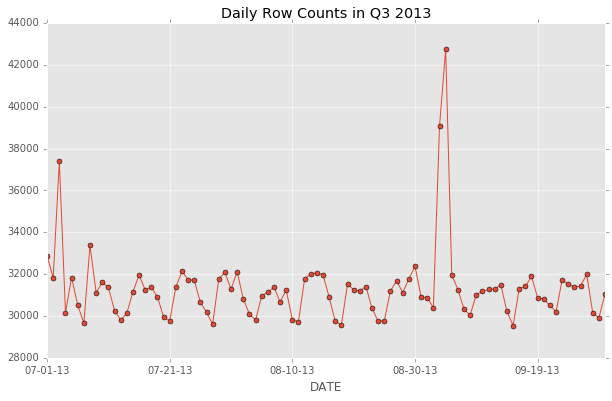

In [17]:
dfp1 = pd.DataFrame.from_dict(c, orient='index').reset_index().rename(
    columns={'index':'DATE', 0:'COUNT'}).sort_values(by='DATE').reset_index(drop=True)
dfp1 = dfp1[(dfp1.DATE != '06-29-13') & (dfp1.DATE != '06-30-13') & (dfp1.DATE != '10-01-13') &
            (dfp1.DATE != '10-02-13') & (dfp1.DATE != '10-03-13') & (dfp1.DATE != '10-04-13')]
dfp1.set_index(['DATE'],inplace=True)
p1 = dfp1.plot(figsize = (10, 6), x_compat=True, marker = 'o', ms = 5, title = 'Daily Row Counts in Q3 2013', legend = None)

+ There is a peak on Sep 03 and Sep 04, 2013 in the daily row counts plot.
+ The seasonality shows that the daily row counts are much lower on weekends than on weekdays. 

### 2. Plot the daily total number of entries & exits across the system for Q3 2013.  

In [18]:
df13q3 = df13[(df13.DATE >= '07-01-13') & (df13.DATE <= '09-30-13')]
dfp2 = df13q3.groupby('DATE')[('ENTRIES_DAILY', 'EXITS_DAILY')].sum()

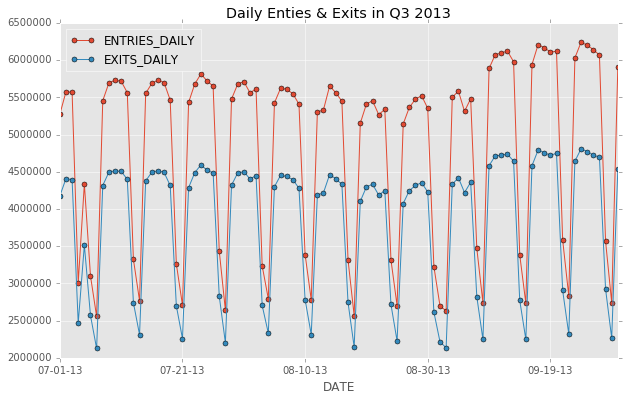

In [19]:
p2 = dfp2.plot(figsize = (10, 6), x_compat=True, marker = 'o', ms = 5, title = 'Daily Enties & Exits in Q3 2013')

+ The strong seasonality shows that the entries and exits numbers on weekends and holidays (July 4th) are much lower than those numbers on weekdays. 
+ The exit nunbers are always less than entry numbers, since some people get out of the subway station through emergency exits. 

### 3. Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

In [20]:
df13q3_penn = df13_m[(df13_m.STATION == '34 ST-PENN STA') & (df13_m.DATE >= '07-01-13') 
                     & (df13_m.DATE <= '09-30-13')].reset_index(drop = True)
df13q3_penn['MON'] = pd.to_datetime(df13q3_penn.DATE, format = '%m-%d-%y').map(lambda x: x.month)
means = df13q3_penn.groupby(['MON', 'DATE'])[('ENTRIES_DAILY', 'EXITS_DAILY')].sum().mean(
    level = 0).rename({7: 'Jul', 8: 'Aug', 9: 'Sep'})
errors = df13q3_penn.groupby(['MON', 'DATE'])[('ENTRIES_DAILY', 'EXITS_DAILY')].sum().std(
    level = 0).rename({7: 'Jul', 8: 'Aug', 9: 'Sep'})

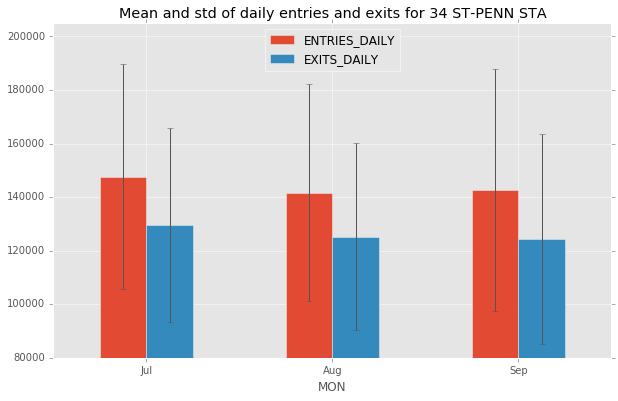

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.ylim(80000, 205000)
means.plot.bar(yerr=errors, ax=ax, rot = 0)
plt.title('Mean and std of daily entries and exits for 34 ST-PENN STA')
plt.show()

+ The bars represent the mean values of daily entries/exits in each month, the arrows represent the standard deviation of them. 

### 4.  Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

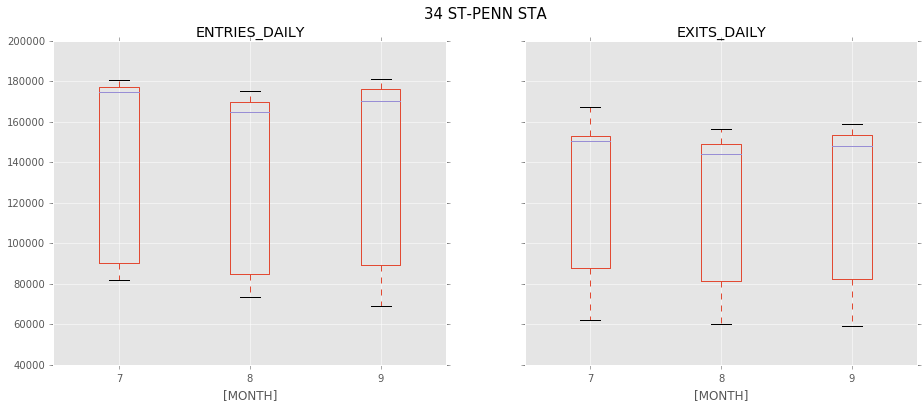

In [22]:
p4 = df13q3_penn.groupby(['MON', 'DATE'])[('ENTRIES_DAILY', 'EXITS_DAILY')].sum()
p4['MONTH'] = list(p4.index.get_level_values('MON'))
p4.boxplot(by='MONTH', figsize = (15, 6))
plt.suptitle("34 ST-PENN STA", size = 15)
plt.show()

+ 25/50/75 percentile are represented by the bottom/middle/upper lines in each boxes.
+ Counts are grouped by entry/exit and months (July/August/September). 

### 5.  Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013.

In [23]:
df13q3_m = pd.merge(df13q3, ucs, how = 'left', on = ['C/A', 'UNIT'])
seriesp5 = df13q3_m.groupby(['STATION', 'DATE'])['BUSYNESS'].sum()
seriesp5.mean(level=0).sort_values().head()

STATION
BROAD CHANNEL     272.206522
ORCHARD BEACH     499.661765
BEACH 105 ST      607.858696
TOMPKINSVILLE     654.260870
AQUEDUCT TRACK    963.369565
Name: BUSYNESS, dtype: float64

+ Given the smallest mean values in Q3 2013 for each station, I'll consider the station closed if the busy-ness < 20. 

In [24]:
#get daily number of closed stations 
dfp5 = seriesp5.to_frame().reset_index()
dfp5['CLOSE'] = [0 if x >= 20 else 1 for x in dfp5['BUSYNESS']]

In [32]:
#get daily number of stations not operating at full capacity
dfp6 = dfp5[dfp5.CLOSE == 0]
NRFC = []
for stat in seriesp5.index.levels[0]:
    n = len(dfp6[dfp6.STATION == stat])
    kmeans = KMeans(n_clusters=2, random_state=0).fit([[dfp6.BUSYNESS[dfp6.STATION == stat].reset_index(drop = True)[i]]
                                                       for i in range(0, n)])
    NRFC += list(kmeans.labels_)
#dfp6['NRFC'] = np.asarray(NRFC)
dfp6 = dfp6.assign(NRFC = NRFC)

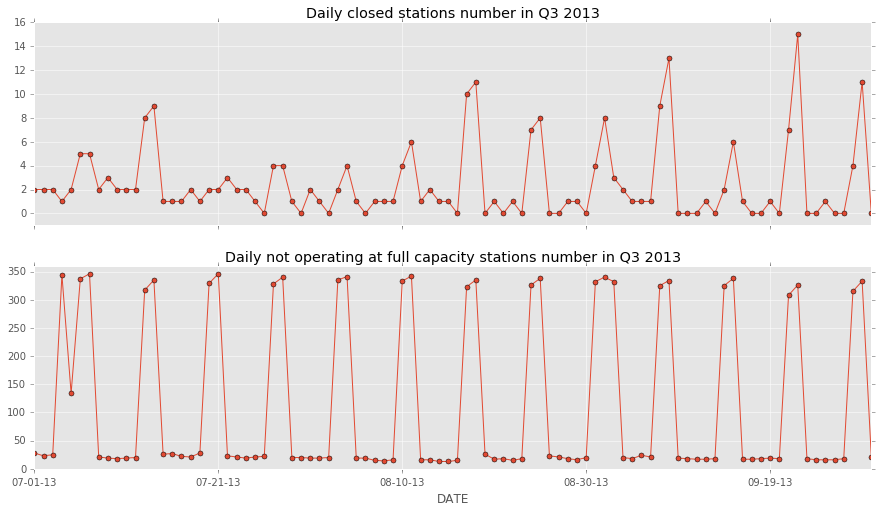

In [33]:
fig, (ax0, ax1) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (15, 8))
dfp5.groupby('DATE')['CLOSE'].sum().plot(marker = 'o', ax = ax0, ms = 5, 
                                         title = 'Daily closed stations number in Q3 2013', legend = None)
ax0.set_ylim([-1, 16])
dfp6.groupby('DATE')['NRFC'].sum().plot(marker = 'o', ax = ax1, ms = 5,
                                        title = 'Daily not operating at full capacity stations number in Q3 2013', legend = None)
ax1.set_ylim([0, 360])
plt.show()

+ The peaks of these two plots often observed at the same dates. 
+ The strong seasonality in the second plot shows that many subway stations were not running at full capacity on holiday (July 4th) and weekends in Q3 2013